# Time Series LSTM model 

In [22]:
df = pd.read_csv("shampoo-sales.csv", index_col='Month', date_parser=dateparse)
df.head()

,Sales
Month,
2011-01-01,266.0
2011-02-01,145.9
2011-03-01,183.1
2011-04-01,119.3
2011-05-01,180.3


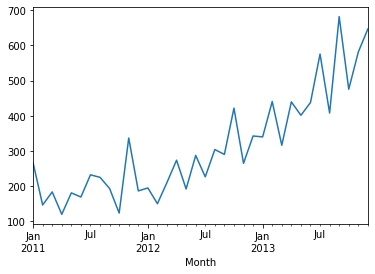

In [59]:
df['Sales'].plot()

- trend 를 제거하여 stationary 한 시계열 생성. model 은 difference를 학습.

In [23]:
differenced = df.diff().dropna()
differenced.head()

,Sales
Month,
2011-02-01,-120.1
2011-03-01,37.2
2011-04-01,-63.8
2011-05-01,61.0
2011-06-01,-11.8


### train/test split
- train : 24 개월
- test : 12 개월

In [60]:
train = np.array(differenced[:-12]).reshape(-1, 1)
test  = np.array(differenced[-12:]).reshape(-1, 1)
train.shape, test.shape

((23, 1), (12, 1))

- feature scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
train_scaled = sc.fit_transform(train)
test_scaled = sc.transform(test)

In [61]:
X_train, y_train = [], []

for i in range(1, len(train_scaled)):
    X_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.expand_dims(X_train, axis=2)

X_train.shape, y_train.shape

((22, 1, 1), (22,))

In [62]:
X_test = []

for i in range(1, len(test_scaled)):
    X_test.append(test_scaled[i-1:i, 0])
    
X_test = np.array(X_test)
X_test = np.expand_dims(X_test, axis=2)

X_test.shape

(11, 1, 1)

- model 생성

In [ ]:
from tensorflow.keras.models import Sequential
import tensorflow as tf

model = Sequential([
    tf.keras.layers.LSTM(20, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=500, batch_size=32)

In [29]:
y_hat = model.predict(X_test)
y_hat = sc.inverse_transform(y_hat)
y_hat

array([[  16.268658],
       [ -57.562267],
       [  83.68384 ],
       [ -75.51363 ],
       [  38.195866],
       [  -9.759319],
       [ -87.42339 ],
       [ 102.024155],
       [-206.02686 ],
       [ 115.86898 ],
       [ -61.703815]], dtype=float32)

model 은 difference를 예측하도록 학습하였으므로, 원래의 시계열로 변환하는 도우미 함수 필요.

In [63]:
def inverse_difference(history, yhat, interval):
    return yhat + history[-interval]

In [64]:
series = df.values

In [68]:
inversed_prediction = []
true_series = []

for i in range(len(y_hat)):
    inversed = inverse_difference(series, y_hat[i], len(y_hat)-i)
    inversed_prediction.append(inversed)

    true_values = series[len(X_train) + i + 1]
    true_series.append(true_values)
    
    print(f'Month={i+1}, Predicted={inversed[0]:.2f}, Expected={expected[0]:.2f}')

Month=1, Predicted=456.67, Expected=475.30
Month=2, Predicted=258.34, Expected=475.30
Month=3, Predicted=522.98, Expected=475.30
Month=4, Predicted=325.79, Expected=475.30
Month=5, Predicted=475.60, Expected=475.30
Month=6, Predicted=565.74, Expected=475.30
Month=7, Predicted=320.18, Expected=475.30
Month=8, Predicted=784.02, Expected=475.30
Month=9, Predicted=269.27, Expected=475.30
Month=10, Predicted=697.17, Expected=475.30
Month=11, Predicted=585.20, Expected=475.30


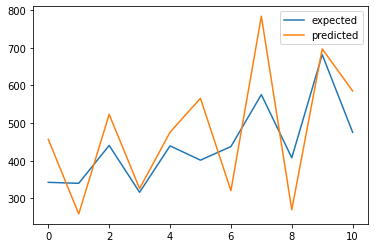

In [69]:
plt.plot(true_series, label='expected')
plt.plot(inversed_prediction, label='predicted')
plt.legend()